In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 100:00:00 -p gpu_quad --gres=gpu:teslaV100s:1 ./ft_ptmb.py



import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, Adapter, loadconceptor
from conceptor.utils import plot_embed_with_label, score
from conceptor.tokenizer import CANCER_CODE

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd
from conceptor import PreTrainer, FineTuner, Adapter, loadconceptor


data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-GENESET-MERGE/15672//data'

df_tpm = pd.read_pickle(os.path.join(data_path,  'TCGA.TPM.TABLE'))
df_label = pd.read_pickle(os.path.join(data_path, 'TCGA.PATIENT.TABLE'))

mpath = '../checkpoint/latest/pretrainer.pt'
# load the pretrained model as a feature extractor
pretrainer = loadconceptor(mpath)

In [2]:
df_label['ptmb'] = df_label['Noushin_pTMB']
df_label['tmb'] = df_label['Noushin_TMB']

In [3]:
task = 'ptmb'

In [4]:
df_label = df_label[~df_label[task].isna()]
df_label = df_label[df_label.cancer_type=='TCGA-BLCA']

dfy = df_label[[task]]
dfy = (dfy - dfy.min()) / (dfy.max() - dfy.min())

dfcx = df_label.cancer_type.apply(lambda x:x.split('-')[-1]).map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfcx = dfcx.loc[dfy.index]

test_idx = dfcx.groupby('cancer_code').sample(frac=0.1).index
train_idx = dfcx.index.difference(test_idx)
print(test_idx.shape, train_idx.shape)


dfcx_train = dfcx.loc[train_idx]
dfy_train = dfy.loc[train_idx]

dfcx_test = dfcx.loc[test_idx]
dfy_test = dfy.loc[test_idx]

(38,) (346,)


In [5]:
ada = Adapter(pretrainer, adp_feature='TMB', lr = 1e-2, weight_decay =0.,
              batch_size = 128, epochs = 100, patience = 20)
ada.adapt(dfcx_train, dfy_train, dfcx_test = dfcx_test, dfy_test = dfy_test)

cellpathway_aggregator.aggregator.attention_weights.cellpathway_38
geneset_aggregator.aggregator.attention_weights.geneset_131
geneset_aggregator.aggregator.attention_weights.geneset_132
geneset_aggregator.aggregator.attention_weights.geneset_133
geneset_aggregator.aggregator.attention_weights.geneset_134
geneset_aggregator.aggregator.attention_weights.geneset_135
geneset_aggregator.aggregator.attention_weights.geneset_136
geneset_aggregator.aggregator.attention_weights.geneset_137
geneset_aggregator.aggregator.attention_weights.geneset_138


  1%|1         | 1/100 [00:02<04:38,  2.81s/it]

Epoch: 1/100 - Train Loss: 0.4732 - Test Loss: 0.4775


  2%|2         | 2/100 [00:04<03:37,  2.22s/it]

Epoch: 2/100 - Train Loss: 0.4666 - Test Loss: 0.4644


  3%|3         | 3/100 [00:06<03:11,  1.97s/it]

Epoch: 3/100 - Train Loss: 0.4521 - Test Loss: 0.4516


  4%|4         | 4/100 [00:08<03:02,  1.90s/it]

Epoch: 4/100 - Train Loss: 0.4397 - Test Loss: 0.4388


  5%|5         | 5/100 [00:09<02:51,  1.80s/it]

Epoch: 5/100 - Train Loss: 0.4278 - Test Loss: 0.4260


  6%|6         | 6/100 [00:11<02:45,  1.76s/it]

Epoch: 6/100 - Train Loss: 0.4140 - Test Loss: 0.4131


  7%|7         | 7/100 [00:13<02:41,  1.74s/it]

Epoch: 7/100 - Train Loss: 0.4012 - Test Loss: 0.3999


  8%|8         | 8/100 [00:14<02:38,  1.72s/it]

Epoch: 8/100 - Train Loss: 0.3899 - Test Loss: 0.3864


  9%|9         | 9/100 [00:16<02:34,  1.70s/it]

Epoch: 9/100 - Train Loss: 0.3766 - Test Loss: 0.3726


 10%|#         | 10/100 [00:18<02:30,  1.67s/it]

Epoch: 10/100 - Train Loss: 0.3627 - Test Loss: 0.3584


 11%|#1        | 11/100 [00:19<02:28,  1.67s/it]

Epoch: 11/100 - Train Loss: 0.3497 - Test Loss: 0.3439


 12%|#2        | 12/100 [00:21<02:29,  1.70s/it]

Epoch: 12/100 - Train Loss: 0.3362 - Test Loss: 0.3290


 13%|#3        | 13/100 [00:23<02:29,  1.71s/it]

Epoch: 13/100 - Train Loss: 0.3219 - Test Loss: 0.3137


 14%|#4        | 14/100 [00:25<02:29,  1.74s/it]

Epoch: 14/100 - Train Loss: 0.3072 - Test Loss: 0.2980


 15%|#5        | 15/100 [00:26<02:29,  1.76s/it]

Epoch: 15/100 - Train Loss: 0.2960 - Test Loss: 0.2821


 16%|#6        | 16/100 [00:28<02:26,  1.75s/it]

Epoch: 16/100 - Train Loss: 0.2804 - Test Loss: 0.2660


 17%|#7        | 17/100 [00:30<02:21,  1.71s/it]

Epoch: 17/100 - Train Loss: 0.2690 - Test Loss: 0.2499


 18%|#8        | 18/100 [00:31<02:22,  1.74s/it]

Epoch: 18/100 - Train Loss: 0.2563 - Test Loss: 0.2337


 19%|#9        | 19/100 [00:33<02:22,  1.76s/it]

Epoch: 19/100 - Train Loss: 0.2444 - Test Loss: 0.2184


 20%|##        | 20/100 [00:35<02:20,  1.75s/it]

Epoch: 20/100 - Train Loss: 0.2338 - Test Loss: 0.2047


 21%|##1       | 21/100 [00:37<02:16,  1.73s/it]

Epoch: 21/100 - Train Loss: 0.2212 - Test Loss: 0.1913


 22%|##2       | 22/100 [00:38<02:14,  1.73s/it]

Epoch: 22/100 - Train Loss: 0.2122 - Test Loss: 0.1782


 23%|##3       | 23/100 [00:40<02:14,  1.75s/it]

Epoch: 23/100 - Train Loss: 0.2024 - Test Loss: 0.1670


 24%|##4       | 24/100 [00:42<02:13,  1.76s/it]

Epoch: 24/100 - Train Loss: 0.1926 - Test Loss: 0.1566


 25%|##5       | 25/100 [00:44<02:13,  1.78s/it]

Epoch: 25/100 - Train Loss: 0.1852 - Test Loss: 0.1472


 26%|##6       | 26/100 [00:46<02:09,  1.75s/it]

Epoch: 26/100 - Train Loss: 0.1782 - Test Loss: 0.1393


 27%|##7       | 27/100 [00:47<02:06,  1.74s/it]

Epoch: 27/100 - Train Loss: 0.1731 - Test Loss: 0.1328


 28%|##8       | 28/100 [00:49<02:03,  1.72s/it]

Epoch: 28/100 - Train Loss: 0.1692 - Test Loss: 0.1287


 29%|##9       | 29/100 [00:50<01:59,  1.68s/it]

Epoch: 29/100 - Train Loss: 0.1645 - Test Loss: 0.1267


 30%|###       | 30/100 [00:53<02:08,  1.84s/it]

Epoch: 30/100 - Train Loss: 0.1623 - Test Loss: 0.1258


 31%|###1      | 31/100 [00:55<02:07,  1.85s/it]

Epoch: 31/100 - Train Loss: 0.1600 - Test Loss: 0.1256


 32%|###2      | 32/100 [00:56<02:02,  1.80s/it]

Epoch: 32/100 - Train Loss: 0.1575 - Test Loss: 0.1254


 33%|###3      | 33/100 [00:58<01:59,  1.79s/it]

Epoch: 33/100 - Train Loss: 0.1567 - Test Loss: 0.1252


 34%|###4      | 34/100 [01:00<01:57,  1.79s/it]

Epoch: 34/100 - Train Loss: 0.1548 - Test Loss: 0.1249


 35%|###5      | 35/100 [01:02<01:56,  1.79s/it]

Epoch: 35/100 - Train Loss: 0.1544 - Test Loss: 0.1247


 36%|###6      | 36/100 [01:03<01:56,  1.82s/it]

Epoch: 36/100 - Train Loss: 0.1536 - Test Loss: 0.1244


 37%|###7      | 37/100 [01:05<01:52,  1.78s/it]

Epoch: 37/100 - Train Loss: 0.1544 - Test Loss: 0.1242


 38%|###8      | 38/100 [01:07<01:49,  1.76s/it]

Epoch: 38/100 - Train Loss: 0.1528 - Test Loss: 0.1240


 39%|###9      | 39/100 [01:09<01:48,  1.78s/it]

Epoch: 39/100 - Train Loss: 0.1537 - Test Loss: 0.1238


 40%|####      | 40/100 [01:10<01:45,  1.76s/it]

Epoch: 40/100 - Train Loss: 0.1523 - Test Loss: 0.1236


 41%|####1     | 41/100 [01:12<01:42,  1.74s/it]

Epoch: 41/100 - Train Loss: 0.1526 - Test Loss: 0.1236


 42%|####2     | 42/100 [01:14<01:42,  1.76s/it]

Epoch: 42/100 - Train Loss: 0.1495 - Test Loss: 0.1234


 43%|####3     | 43/100 [01:16<01:39,  1.75s/it]

Epoch: 43/100 - Train Loss: 0.1510 - Test Loss: 0.1233


 44%|####4     | 44/100 [01:17<01:36,  1.73s/it]

Epoch: 44/100 - Train Loss: 0.1501 - Test Loss: 0.1232


 45%|####5     | 45/100 [01:19<01:34,  1.72s/it]

Epoch: 45/100 - Train Loss: 0.1489 - Test Loss: 0.1231


 46%|####6     | 46/100 [01:21<01:32,  1.72s/it]

Epoch: 46/100 - Train Loss: 0.1504 - Test Loss: 0.1230


 47%|####6     | 47/100 [01:22<01:31,  1.73s/it]

Epoch: 47/100 - Train Loss: 0.1498 - Test Loss: 0.1230


 48%|####8     | 48/100 [01:24<01:31,  1.75s/it]

Epoch: 48/100 - Train Loss: 0.1506 - Test Loss: 0.1229


 49%|####9     | 49/100 [01:26<01:29,  1.76s/it]

Epoch: 49/100 - Train Loss: 0.1504 - Test Loss: 0.1229


 50%|#####     | 50/100 [01:28<01:26,  1.73s/it]

Epoch: 50/100 - Train Loss: 0.1496 - Test Loss: 0.1229


 51%|#####1    | 51/100 [01:30<01:26,  1.76s/it]

Epoch: 51/100 - Train Loss: 0.1508 - Test Loss: 0.1228


 52%|#####2    | 52/100 [01:31<01:24,  1.76s/it]

Epoch: 52/100 - Train Loss: 0.1489 - Test Loss: 0.1228


 53%|#####3    | 53/100 [01:33<01:22,  1.75s/it]

Epoch: 53/100 - Train Loss: 0.1494 - Test Loss: 0.1228


 54%|#####4    | 54/100 [01:35<01:21,  1.78s/it]

Epoch: 54/100 - Train Loss: 0.1495 - Test Loss: 0.1228


 55%|#####5    | 55/100 [01:37<01:18,  1.75s/it]

Epoch: 55/100 - Train Loss: 0.1503 - Test Loss: 0.1228


 56%|#####6    | 56/100 [01:38<01:16,  1.73s/it]

Epoch: 56/100 - Train Loss: 0.1493 - Test Loss: 0.1227


 57%|#####6    | 57/100 [01:40<01:15,  1.75s/it]

Epoch: 57/100 - Train Loss: 0.1507 - Test Loss: 0.1226


 58%|#####8    | 58/100 [01:42<01:14,  1.77s/it]

Epoch: 58/100 - Train Loss: 0.1482 - Test Loss: 0.1226


 59%|#####8    | 59/100 [01:44<01:12,  1.78s/it]

Epoch: 59/100 - Train Loss: 0.1491 - Test Loss: 0.1226


 60%|######    | 60/100 [01:45<01:09,  1.74s/it]

Epoch: 60/100 - Train Loss: 0.1469 - Test Loss: 0.1225


 61%|######1   | 61/100 [01:47<01:07,  1.73s/it]

Epoch: 61/100 - Train Loss: 0.1488 - Test Loss: 0.1225


 62%|######2   | 62/100 [01:49<01:05,  1.72s/it]

Epoch: 62/100 - Train Loss: 0.1473 - Test Loss: 0.1225


 63%|######3   | 63/100 [01:50<01:02,  1.69s/it]

Epoch: 63/100 - Train Loss: 0.1480 - Test Loss: 0.1225


 64%|######4   | 64/100 [01:52<01:01,  1.71s/it]

Epoch: 64/100 - Train Loss: 0.1473 - Test Loss: 0.1224


 65%|######5   | 65/100 [01:54<01:01,  1.76s/it]

Epoch: 65/100 - Train Loss: 0.1456 - Test Loss: 0.1224


 66%|######6   | 66/100 [01:56<00:59,  1.75s/it]

Epoch: 66/100 - Train Loss: 0.1484 - Test Loss: 0.1224


 67%|######7   | 67/100 [01:57<00:57,  1.74s/it]

Epoch: 67/100 - Train Loss: 0.1472 - Test Loss: 0.1223


 68%|######8   | 68/100 [01:59<00:54,  1.72s/it]

Epoch: 68/100 - Train Loss: 0.1449 - Test Loss: 0.1224


 69%|######9   | 69/100 [02:01<00:54,  1.75s/it]

Epoch: 69/100 - Train Loss: 0.1465 - Test Loss: 0.1224


 70%|#######   | 70/100 [02:03<00:54,  1.80s/it]

Epoch: 70/100 - Train Loss: 0.1452 - Test Loss: 0.1224


 71%|#######1  | 71/100 [02:05<00:51,  1.77s/it]

Epoch: 71/100 - Train Loss: 0.1467 - Test Loss: 0.1225


 72%|#######2  | 72/100 [02:06<00:50,  1.79s/it]

Epoch: 72/100 - Train Loss: 0.1474 - Test Loss: 0.1225


 73%|#######3  | 73/100 [02:08<00:47,  1.76s/it]

Epoch: 73/100 - Train Loss: 0.1470 - Test Loss: 0.1226


 74%|#######4  | 74/100 [02:10<00:45,  1.76s/it]

Epoch: 74/100 - Train Loss: 0.1476 - Test Loss: 0.1226


 75%|#######5  | 75/100 [02:12<00:44,  1.78s/it]

Epoch: 75/100 - Train Loss: 0.1470 - Test Loss: 0.1226


 76%|#######6  | 76/100 [02:13<00:42,  1.78s/it]

Epoch: 76/100 - Train Loss: 0.1450 - Test Loss: 0.1227


 77%|#######7  | 77/100 [02:15<00:41,  1.78s/it]

Epoch: 77/100 - Train Loss: 0.1452 - Test Loss: 0.1227


 78%|#######8  | 78/100 [02:17<00:39,  1.77s/it]

Epoch: 78/100 - Train Loss: 0.1469 - Test Loss: 0.1227


 79%|#######9  | 79/100 [02:19<00:36,  1.76s/it]

Epoch: 79/100 - Train Loss: 0.1454 - Test Loss: 0.1227


 80%|########  | 80/100 [02:20<00:35,  1.76s/it]

Epoch: 80/100 - Train Loss: 0.1456 - Test Loss: 0.1227


 81%|########1 | 81/100 [02:22<00:33,  1.74s/it]

Epoch: 81/100 - Train Loss: 0.1473 - Test Loss: 0.1228


 82%|########2 | 82/100 [02:24<00:30,  1.68s/it]

Epoch: 82/100 - Train Loss: 0.1452 - Test Loss: 0.1228


 83%|########2 | 83/100 [02:26<00:29,  1.72s/it]

Epoch: 83/100 - Train Loss: 0.1451 - Test Loss: 0.1228


 84%|########4 | 84/100 [02:28<00:29,  1.85s/it]

Epoch: 84/100 - Train Loss: 0.1446 - Test Loss: 0.1228


 85%|########5 | 85/100 [02:30<00:28,  1.87s/it]

Epoch: 85/100 - Train Loss: 0.1464 - Test Loss: 0.1229


 86%|########6 | 86/100 [02:31<00:25,  1.80s/it]

Epoch: 86/100 - Train Loss: 0.1451 - Test Loss: 0.1229


 86%|########6 | 86/100 [02:33<00:24,  1.79s/it]

Epoch: 87/100 - Train Loss: 0.1450 - Test Loss: 0.1229
Stopping early at epoch 87. No improvement in validation loss for 20 consecutive epochs.



rm: refusing to remove ‘.’ or ‘..’ directory: skipping ‘./’


100%|##########| 24/24 [00:01<00:00, 12.17it/s]


Saving the model to ../checkpoint/latest/pretrainer_ptmb.pt


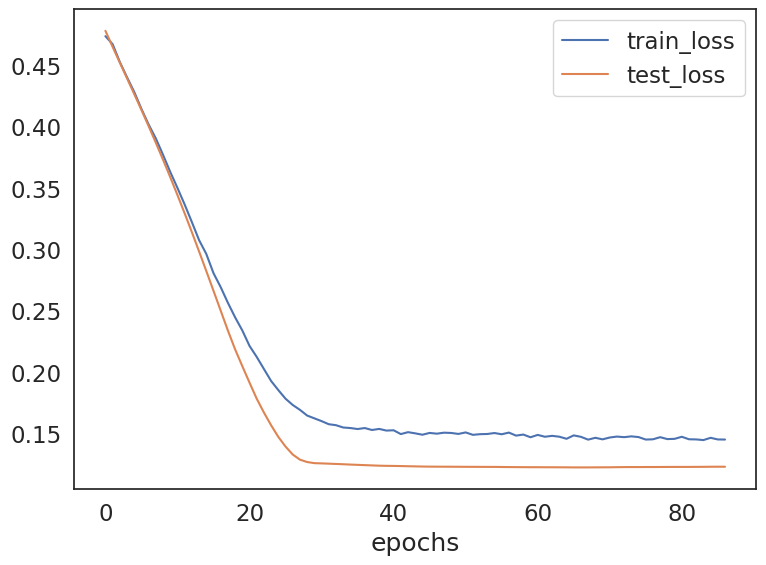

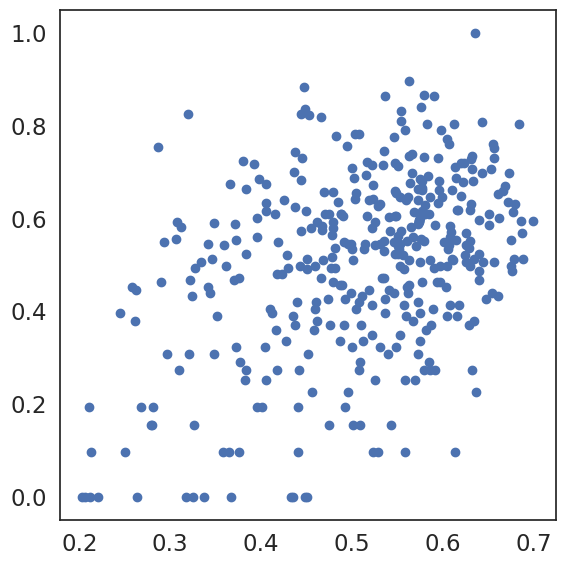

In [6]:
dfp = pd.DataFrame(ada.performace, columns=  ['epochs', 'train_loss', 'test_loss']).set_index('epochs')
dfp.to_csv('training_history_%s.csv' % task)
fig, ax = plt.subplots(figsize=(8,6))
dfp.plot(ax=ax)
fig.tight_layout()
fig.savefig('training_history_%s.jpg' % task)


dfe, dfp = ada.pretrainer.predict(dfcx, batch_size = 16)
dfeo, dfp = pretrainer.predict(dfcx, batch_size = 16)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(dfe.TMB, dfy[task])
fig.tight_layout()
fig.savefig('true_vs_pred_%s.jpg' % task)

ada.pretrainer.save('../checkpoint/latest/pretrainer_%s.pt' % task)